# Разработка модели

В этой тетрадке вы должны создать свою модель и сохранить ее веса, чтобы потом их можно было загрузить уже из телеграм бота. Сейчас здесь находится бейзлайн, который вам нужно адаптировать под свой датасет. Идеологически этот проект про ислледовательскую работу, мы хотим, чтобы Вы научились решать задачу классификации с нуля. Поэтому основное время всего проекта должно занять создание модели и ее оптимизация. 

В качестве фреймворка для всей работы мы предлагаем Вам fast.ai. Эта бибилотека содержит очень много полезных инструментов и проста в освоении. По fast ai есть курс, но он использует устаревшую версию библиотеки, которую нужно устанавливать, копируя папку с гитхаба. Если Вы установили библиотеку через pip, то используйте документацию https://docs.fast.ai/vision.html#vision

Список вещей, которые стоит сделать в проекте.  
* Подберите лучшую модель
* Используте LrFinder
* Поберите стратегию для изменения learning rate
* Используйте аугментации на обучающем датасете.
* Используйте Test Time Augmentation (классфификация по-разному аугментированной картинки и усреднение предсказаний).

Не ограничивайтесь этим списком и попытайтесь найти или придумать другие пути для улучшения своей модели, креативность только приветствуется. 

Во время разработки в этой тетради может содрежаться много разного и несвязного кода, но к концу проекта постарайтесь оформить тетрадку с одной моделью, чтобы другие люди могли использовать вашу работу.

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

from fastai.vision import *

plt.ion()

In [0]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"asivova","key":"913c2ad5270ad216a7a1c812287d7bd3"}'}

In [0]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 63 Jun 25 14:18 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# List available datasets.
!kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
himanshupoddar/zomato-bangalore-restaurants                 Zomato Bangalore Restaurants                         88MB  2019-03-31 09:48:43           5430  
thegurus/spanish-high-speed-rail-system-ticket-pricing      Spanish High Speed Rail tickets pricing - Renfe      27MB  2019-05-10 06:50:30           1435  
taniaj/australian-election-2019-tweets                      Australian Election 2019 Tweets                      29MB  2019-05-21 09:41:38            872  
brittabettendorf/berlin-airbnb-data                         Berlin Airbnb Data                                   89MB  2019-03-05 09:23:00           1745  
snocco/missing-migrants-project                             Miss

In [0]:
# Copy the stackoverflow data set locally.
!kaggle competitions download -c plant-seedlings-classification  

  0% 0.00/5.13k [00:00<?, ?B/s]
100% 5.13k/5.13k [00:00<00:00, 4.38MB/s]
 84% 72.0M/86.0M [00:01<00:00, 57.2MB/s]
100% 86.0M/86.0M [00:01<00:00, 71.0MB/s]
100% 1.60G/1.60G [00:18<00:00, 113MB/s] 
100% 1.60G/1.60G [00:18<00:00, 93.3MB/s]


In [0]:
!unzip train.zip -d data

Archive:  train.zip
   creating: data/train/
   creating: data/train/Fat Hen/
  inflating: data/train/Fat Hen/5bdfa3a44.png  
  inflating: data/train/Fat Hen/a86b9c0cd.png  
  inflating: data/train/Fat Hen/f3f6559bf.png  
  inflating: data/train/Fat Hen/946b48f62.png  
  inflating: data/train/Fat Hen/4d7fd4020.png  
  inflating: data/train/Fat Hen/2509e5bc5.png  
  inflating: data/train/Fat Hen/e2462573b.png  
  inflating: data/train/Fat Hen/7e98e4aa6.png  
  inflating: data/train/Fat Hen/075cb6666.png  
  inflating: data/train/Fat Hen/b43d0a350.png  
  inflating: data/train/Fat Hen/afac20b21.png  
  inflating: data/train/Fat Hen/4d2efbb45.png  
  inflating: data/train/Fat Hen/f0923dcd6.png  
  inflating: data/train/Fat Hen/180f41d53.png  
  inflating: data/train/Fat Hen/bfdeafadd.png  
  inflating: data/train/Fat Hen/ac6625b0f.png  
  inflating: data/train/Fat Hen/ba5c8f87f.png  
  inflating: data/train/Fat Hen/e7d278e0e.png  
  inflating: data/train/Fat Hen/efaab2370.png  
  inflatin

In [0]:
!unzip sample_submission.csv.zip -d data

Archive:  sample_submission.csv.zip
  inflating: data/sample_submission.csv  


In [0]:
!unzip test.zip -d data

Archive:  test.zip
   creating: data/test/
  inflating: data/test/c0461776c.png  
  inflating: data/test/4bbfd1e05.png  
  inflating: data/test/1d0cbd819.png  
  inflating: data/test/93079d970.png  
  inflating: data/test/856f2910a.png  
  inflating: data/test/976e4e079.png  
  inflating: data/test/b31292706.png  
  inflating: data/test/29bab7cad.png  
  inflating: data/test/37297a64c.png  
  inflating: data/test/f2dc546ca.png  
  inflating: data/test/b6a3f7876.png  
  inflating: data/test/8874bba69.png  
  inflating: data/test/1459e96a0.png  
  inflating: data/test/9a3f20121.png  
  inflating: data/test/5315c2dca.png  
  inflating: data/test/b7a7f6390.png  
  inflating: data/test/20e562fd5.png  
  inflating: data/test/e3f50adfc.png  
  inflating: data/test/6ba4ef411.png  
  inflating: data/test/acdb75e00.png  
  inflating: data/test/e0ec5b6a1.png  
  inflating: data/test/219fd68d5.png  
  inflating: data/test/41f1c3cdb.png  
  inflating: data/test/8c98a6e9b.png  
  inflating: data/tes

In [0]:
import numpy as np
from fastai import *
from fastai.vision import *
from pathlib import Path


In [0]:
#Присваиваем  переменной PATH имя папки data/ :
#А path-train data/train, где хранится тренировочные данные

PATH = "data/"
path_train="data/train"

#Выводим на экран содержимое папки  PATH (data/) с помощью функции listdir модуля os:

print(os.listdir(PATH))
os.listdir(path_train)

['test', 'train', 'sample_submission.csv']


['Loose Silky-bent',
 'Charlock',
 'Scentless Mayweed',
 'Common Chickweed',
 'Small-flowered Cranesbill',
 'Maize',
 'Sugar beet',
 'Cleavers',
 'Fat Hen',
 'Common wheat',
 'Shepherds Purse',
 'Black-grass']

In [0]:
#В этом конкретном наборе данных имя папки представляет метку класса всех изображений, присутствующих в этой папке. 
#Извлекаю названия меток из имени папки автоматически через библиотеку fastai: ImageDataBunch.from_folderфункцию, которая позволяет автоматически извлекать имена меток из имени папки. 
#Кроме того, ImageDataBunchкласс позволяет легко создавать обучающие и проверочные наборы с изображениями и метками. 
#После загрузки данных мы также можем нормализирую данные, используя  .normalizeпараметры ImageNet.
np.random.seed(8)
bs=64
sz=224
tfms = get_transforms(flip_vert=True, max_warp=0)

data = ImageDataBunch.from_folder(path_train, 
                                  valid_pct=0.2,
                                  train=".",

                                  ds_tfms=tfms,
                                  size=sz,bs=bs, 
                                  num_workers=0).normalize(imagenet_stats)

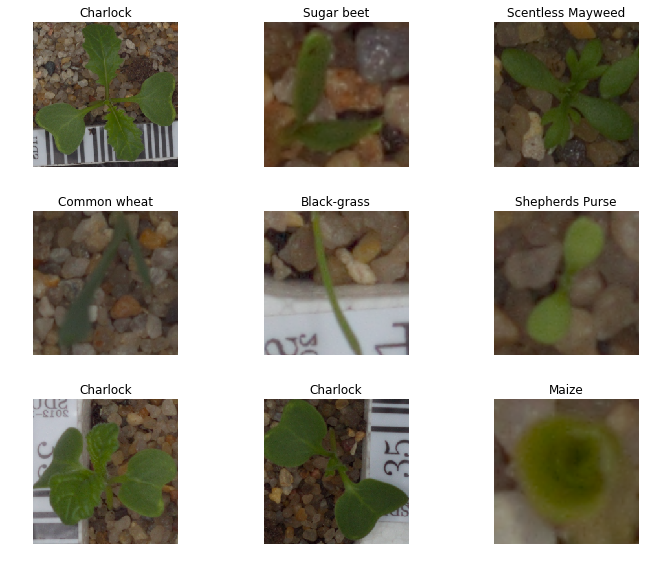

In [0]:
#Посмотрим случайную выборку
data.show_batch(rows=3, figsize=(10,8))

In [0]:
#Выведем классы train/ (data/train) и узнаем сколько их:
print(data.classes)
len(data.classes),data.c


['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


(12, 12)

In [0]:
#Выбираю в качестве архитектуры resnet 50, т.к. он позволяет с легкостью увеличить точность и является предварительно обученной  
#https://download.pytorch.org/models/resnet50-19c8e357.pth
arch = models.resnet50
learn = cnn_learner(data, models.resnet50, metrics = accuracy, pretrained=True)


In [0]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.293656,0.574936,0.793684,46:31
1,0.708973,0.344760,0.883158,46:53
2,0.483321,0.286510,0.902105,47:04


In [0]:
#сохраняем веса
learn.save('stage-1.pth',PATH)

PosixPath('data/train/models/stage-1.pth.pth')

AttributeError: ignored

['87cafd4dc.png',
 '05598e057.png',
 'abf3ee5df.png',
 'e682d2f54.png',
 '8ee5d6835.png',
 'd4887c996.png',
 'b8ac37dcd.png',
 '27d658aea.png',
 '70aa9e547.png',
 'a0b1ab201.png']

Name: fastai
Version: 1.0.53.post2
--
Name: torch
Version: 1.1.0


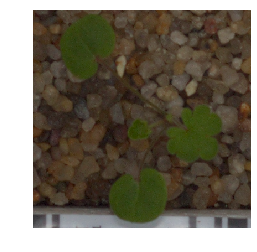

(394, 394, 3)

In [0]:
#train_Cranesbill_img_0[:4][:2] 

array([[[0.282353, 0.211765, 0.141176],
        [0.286275, 0.211765, 0.14902 ],
        [0.286275, 0.211765, 0.152941],
        [0.286275, 0.211765, 0.156863],
        ...,
        [0.356863, 0.294118, 0.2     ],
        [0.360784, 0.301961, 0.203922],
        [0.356863, 0.298039, 0.207843],
        [0.376471, 0.321569, 0.231373]],

       [[0.286275, 0.215686, 0.137255],
        [0.309804, 0.239216, 0.168627],
        [0.286275, 0.211765, 0.14902 ],
        [0.286275, 0.215686, 0.160784],
        ...,
        [0.356863, 0.282353, 0.184314],
        [0.341176, 0.266667, 0.168627],
        [0.34902 , 0.278431, 0.184314],
        [0.345098, 0.278431, 0.184314]]], dtype=float32)

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.2), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do

ModuleNotFoundError: ignored

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fe68bc39f60>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: ignored

# В этой части нужно загрузить датасет, разделить его на тренировочную и валидационную выборки и разложить картинки по папкам, чтобы в одной папке лежали картинки одного класса.

Эта часть очень сильно зависит от датасета, который вы выбрали, поэтому включить ее в бейзлайн не получится. Если вы выберете датасет, но застрянете на этом шаге, то напишите мне и я помогу разобраться. Это очень важно и не стоит откладывать, так как без приведения датасета к удобному формату вы не сможете продолжить проект.

В моем случае нужно просто загрузить датасет с каггла и распаковать https://www.kaggle.com/joosthazelzet/lego-brick-images/version/1 

# Теперь перейдем к созданию модели

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: ignored

# Оставлось обучить модель и проверить ее точность.

**НЕ ЗАБЫВАЙТЕ, ЧТО ПО УМОЛЧАНИЮ ВСЕ СЛОИ, КРОМЕ ПОСЛЕДНИХ ЗАМОРОЖЕНЫ**

# Сохраним веса

В улучшении бейзлайна и получении новых идей Вам сильно поможет документация fast ai. Начать стоит с раздела про vision, а потом посмотреть туториалы, чтобы понимать на что вообще способна библиотека.

Из интересных идей, которые можно попробовать: можно проводить пару эпох обучения сначала на более маленьких картинках, чем итоговые (тогда при обучении на больших картинках у сети уже будут более менее неплохие веса). 

In [0]:
#data.train_ds